In [1]:
first_time = True

In [2]:
# --- Standard Library ---
import math
import random
import time
import warnings
from collections import defaultdict
from datetime import datetime, timedelta, timezone

# --- Third-party Libraries ---
import numpy as np
import pandas as pd
import ijson
import dtale

# --- Matplotlib ---
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.patches import Rectangle, Polygon as MplPolygon
from matplotlib.ticker import FixedLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

# --- Shapely ---
from shapely.geometry import (
    Polygon, MultiPolygon, LineString, GeometryCollection, box
)
from shapely.ops import unary_union, polygonize

# --- IPython / Widgets ---
from IPython.display import display
from ipywidgets import Checkbox, HBox, VBox, HTML

# --- Interactive Tools ---
import mplcursors

# --- Enable Interactive Plotting ---
%matplotlib widget


In [3]:
import os

# Only define injected_file_path if not set externally
try:
    injected_file_path
except NameError:
    injected_file_path = "/Users/Ludwig/Documents/GitHub/data_demo/637f0d5f78f0cb97981425de__post4.json"

# Always assign file_path
file_path = injected_file_path

file_id = os.path.splitext(os.path.basename(file_path))[0]

# Extract post folder (assumes format has '__postX' at the end)
post_folder = file_id.split("__")[-1]  # e.g. 'post1'
output_dir = os.path.join("./output", post_folder)
os.makedirs(output_dir, exist_ok=True)

# Plot counter starts at 0 for each notebook run
plot_counter = 0


In [4]:
def save_plot(name_suffix):
    global plot_counter
    plot_counter += 1
    filename = f"{output_dir}/plot_{file_id}_{plot_counter}_{name_suffix}.png"
    plt.savefig(filename, dpi=300)
    print(f"Saved plot to {filename}")

In [5]:
def save_df(df, name_suffix):
    filename = f"{output_dir}/df_{file_id}_{name_suffix}.csv"
    df.to_csv(filename, index=False)
    print(f"Saved DataFrame to {filename}")

In [6]:
# Convert timestamp to Edie time bin
def time_bin(t, dt):
    return int(t // dt)

# Convert x-position to Edie space bin
def space_bin(x, dx):
    return int(x // dx)

# Create the main parser and Edie statistics accumulator
def compute_edie_stats(file_path, direction=-1, dx=160, dt=60):
    edie_grid = defaultdict(lambda: {"distance": 0.0, "time": 0.0, "count": 0})
    got_date = False
    count = 0

    with open(file_path, 'r') as input_file:
        parser = ijson.items(input_file, 'item', use_float=True)

        for record in parser:
            if record["direction"] != direction:
                continue

            timestamps = np.array(record["timestamp"])
            x_positions = np.array(record["x_position"])
            if len(timestamps) < 2:
                continue

            if not got_date:
                date = datetime.fromtimestamp(timestamps[0]).date()
                got_date = True

            for i in range(1, len(timestamps)):
                t0, t1 = timestamps[i - 1], timestamps[i]
                x0, x1 = x_positions[i - 1], x_positions[i]

                dt_seg = t1 - t0
                dx_seg = (x1 - x0) * direction
                if dt_seg <= 0 or dx_seg <= 0:
                    continue

                t_bins = list(range(time_bin(t0, dt), time_bin(t1, dt) + 1))
                x_bins = list(range(space_bin(x0, dx), space_bin(x1, dx) + 1))

                # Spread segment contributions to all intersected Edie cells
                for tb in t_bins:
                    for xb in x_bins:
                        edie_grid[(xb, tb)]["distance"] += dx_seg
                        edie_grid[(xb, tb)]["time"] += dt_seg
                        edie_grid[(xb, tb)]["count"] += 1

            count += 1
            if count % 100000 == 0:
                print(f"Processed {count} trajectories...")

    print(f"✅ Finished parsing {count} trajectories.")
    return edie_grid, date

# Create the main parser and Edie statistics accumulator
def compute_edie_stats_threshold(file_path, direction=-1, dx=160, dt=60, light_thresh=20, heavy_thresh=10):
    edie_grid = defaultdict(lambda: {"distance": 0.0, "time": 0.0, "count": 0})
    got_date = False
    count = 0

    with open(file_path, 'r') as input_file:
        parser = ijson.items(input_file, 'item', use_float=True)

        for record in parser:
            if record["direction"] != direction:
                continue

            timestamps = np.array(record["timestamp"])
            x_positions = np.array(record["x_position"])
            if len(timestamps) < 2:
                continue

            if not got_date:
                date = datetime.fromtimestamp(timestamps[0]).date()
                got_date = True

            for i in range(1, len(timestamps)):
                t0, t1 = timestamps[i - 1], timestamps[i]
                x0, x1 = x_positions[i - 1], x_positions[i]

                dt_seg = t1 - t0
                dx_seg = (x1 - x0) * direction
                if dt_seg <= 0 or dx_seg <= 0:
                    continue

                t_bins = list(range(time_bin(t0, dt), time_bin(t1, dt) + 1))
                x_bins = list(range(space_bin(x0, dx), space_bin(x1, dx) + 1))

                for tb in t_bins:
                    for xb in x_bins:
                        edie_grid[(xb, tb)]["distance"] += dx_seg
                        edie_grid[(xb, tb)]["time"] += dt_seg
                        edie_grid[(xb, tb)]["count"] += 1

            count += 1
            if count % 100000 == 0:
                print(f"Processed {count} trajectories...")

    print(f"✅ Finished parsing {count} trajectories.")
    
    # Apply dual threshold filtering
    edie_grid_light = {}
    edie_grid_heavy = {}

    for key, cell in edie_grid.items():
        if cell["time"] == 0:
            continue
        speed_mph = (cell["distance"] / cell["time"]) * 3600 / 5280
        if speed_mph <= light_thresh:
            edie_grid_light[key] = cell
        if speed_mph <= heavy_thresh:
            edie_grid_heavy[key] = cell

    print(f"🌕 Edie cells ≤ {light_thresh} mph: {len(edie_grid_light)}")
    print(f"🔴 Edie cells ≤ {heavy_thresh} mph: {len(edie_grid_heavy)}")

    return edie_grid_light, edie_grid_heavy, date



def compute_edie_metrics(edie_grid, dx=160, dt=60):
    edie_metrics = {}

    # Edie cell area in space-time (W_X)
    WX = dx * dt  # feet * seconds

    for (xb, tb), stats in edie_grid.items():
        TD = stats["distance"]  # total distance traveled in feet
        TT = stats["time"]      # total time spent in seconds

        # Edie definitions:
        # Flow q = TD / WX  (vehicles * feet / (feet * seconds) = vehicles / second)
        # Density k = TT / WX  (vehicle-seconds / (feet * seconds) = vehicles / foot)
        # Speed v = TD / TT  (feet / second), if TT > 0

        q = TD / WX if WX > 0 else 0  # flow in veh/sec
        k = TT / WX if WX > 0 else 0  # density in veh/ft
        v = TD / TT if TT > 0 else 0  # speed in ft/sec

        # Optionally convert to more familiar units:
        v_mph = v * 3600 / 5280         # feet/sec -> miles/hour
        k_vpm = k * 5280                # veh/foot -> veh/mile
        q_vph = q * 3600                # veh/sec -> veh/hour

        edie_metrics[(xb, tb)] = {
            "flow_vph": q_vph,
            "density_vpm": k_vpm,
            "speed_mph": v_mph,
            "raw": {
                "TD": TD,
                "TT": TT,
                "WX": WX,
                "flow": q,
                "density": k,
                "speed": v
            }
        }

    return edie_metrics


def interactive_plot_congestion_with_edie(trajectories, edie_grid, polygons_by_label, dx=160, dt=30):

    # 🎨 Colors
    label_colors = {
        'light_sub_20': "#04ff00",
        'heavy_sub_10': "#ff0000",
    }

    # Setup figure
    plt.rc('font', family='serif', size=14)
    fig, ax = plt.subplots(figsize=(12, 4))

    # Plot all trajectories
    all_timestamps, all_positions, all_speeds = [], [], []
    for traj in trajectories:
        all_timestamps.extend(traj["timestamp"])
        all_positions.extend(np.array(traj["x_position"]) / 5280)
        all_speeds.extend(traj["speed_mph"])

    jet = plt.cm.jet
    colors = [jet(x) for x in np.linspace(1, 0.5, 256)]
    green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)

    im = ax.scatter(all_timestamps, all_positions, c=all_speeds, cmap=green_to_red, vmin=0, vmax=80, s=0.1, alpha=0)
    #plt.colorbar(im, label='Speed (mph)', pad=0.01)

    from matplotlib.cm import ScalarMappable
    from matplotlib.colors import Normalize

    # Before the Edie cells loop, set up the colormap and normalization:
    norm = Normalize(vmin=0, vmax=55)  # speed range mph
    sm = ScalarMappable(cmap=green_to_red, norm=norm)
    sm.set_array([])  # Required for colorbar, even if empty
    # Plot Edie cells as semi-transparent rectangles
    for (x_bin, t_bin), cell in edie_grid.items():
        distance = cell["distance"]
        time = cell["time"]

        if time == 0:
            continue

        speed = distance / time  # ft/s
        speed_mph = speed * 3600 / 5280

        speed_for_color = min(speed_mph, 55)  # clamp at 55 mph max for color
        color = green_to_red(norm(speed_for_color))

        # Convert to same coordinates as plot
        x0 = x_bin * dx / 5280
        x1 = (x_bin + 1) * dx / 5280

        t_start = t_bin * dt
        t_end = (t_bin + 1) * dt

        rect = Rectangle((t_start, x0), t_end - t_start, x1 - x0,
                         facecolor=color, edgecolor='none', alpha=1, zorder=0)
        ax.add_patch(rect)

    plt.colorbar(sm, ax=ax, label='Speed (mph)', pad=0.01)
    # Format x-axis
    ticks_loc = ax.get_xticks().tolist()
    ax.set_xticks(ticks_loc)
    labels = [datetime.fromtimestamp(ts, tz=timezone(timedelta(hours=-6))).strftime('%H:%M:%S') for ts in ticks_loc]
    ax.set_xticklabels(labels, rotation=45)
    ax.set_xlabel("Time")
    ax.set_ylabel("Mile Marker")
    ax.invert_yaxis()

    # Hover coordinate format
    def format_hover_info(x, y):
        try:
            dt = datetime.fromtimestamp(x, tz=timezone(timedelta(hours=-6)))
            return f"Time: {dt.strftime('%H:%M')}, Mile: {y:.2f}"
        except:
            return f"Time: {x:.2f}, Mile: {y:.2f}"
    ax.format_coord = format_hover_info

    # Plot polygons with toggles
    polygon_patches = {}
    toggles = []

    for label, polygons in polygons_by_label.items():
        color = label_colors.get(label, f"#{random.randint(0, 0xFFFFFF):06x}")
        rgba = mcolors.to_rgba(color, alpha=1.0)
        patches = []

        shapes = polygons if isinstance(polygons, list) else list(polygons.geoms) if hasattr(polygons, "geoms") else [polygons]

        for poly in shapes:
            coords = np.array(poly.exterior.coords)
            coords[:, 1] /= 5280
            patch = MplPolygon(coords, facecolor=rgba, edgecolor='black', linewidth=0.8)
            ax.add_patch(patch)
            patches.append(patch)

        checkbox = Checkbox(value=True, indent=False, layout={'width': '15px'})
        label_html = HTML(f"<span style='color:{color}; font-weight:bold;'>{label.replace('_', ' ').title()}</span>")
        toggles.append(HBox([checkbox, label_html], layout={'align_items': 'center', 'gap': '4px'}))
        polygon_patches[label] = (patches, checkbox)

    def update_display(change=None):
        for label, (patches, checkbox) in polygon_patches.items():
            for patch in patches:
                patch.set_visible(checkbox.value)
        fig.canvas.draw_idle()

    for _, (_, checkbox) in polygon_patches.items():
        checkbox.observe(update_display, names='value')
    update_display()

    display(VBox(toggles))
    plt.tight_layout()
    save_plot("cong_and_edie")
    plt.show()

def interactive_plot_edies_polys(trajectories, edie_grid_light, edie_grid_heavy, polygons_by_label, dx=160, dt=30):
    # 🎨 Colors
    label_colors = {
        'light_sub_20': "#04ff00",
        'heavy_sub_10': "#ff0000",
    }

    # Setup figure
    plt.rc('font', family='serif', size=14)
    fig, ax = plt.subplots(figsize=(12, 4))

    # Plot all trajectories
    all_timestamps, all_positions, all_speeds = [], [], []
    for traj in trajectories:
        all_timestamps.extend(traj["timestamp"])
        all_positions.extend(np.array(traj["x_position"]) / 5280)
        all_speeds.extend(traj["speed_mph"])

    # Colormap
    jet = plt.cm.jet
    colors = [jet(x) for x in np.linspace(1, 0.5, 256)]
    green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)
    im = ax.scatter(all_timestamps, all_positions, c=all_speeds, cmap=green_to_red, vmin=0, vmax=80, s=0.1, alpha=0)

    # Colorbar for Edie cells
    norm = Normalize(vmin=0, vmax=55)
    sm = ScalarMappable(cmap=green_to_red, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Speed (mph)', pad=0.01)

    # Format x-axis as timestamps
    ticks_loc = ax.get_xticks().tolist()
    ax.set_xticks(ticks_loc)
    labels = [datetime.fromtimestamp(ts, tz=timezone(timedelta(hours=-6))).strftime('%H:%M:%S') for ts in ticks_loc]
    ax.set_xticklabels(labels, rotation=45)
    ax.set_xlabel("Time")
    ax.set_ylabel("Mile Marker")
    ax.invert_yaxis()

    # Coordinate display
    def format_hover_info(x, y):
        try:
            dt = datetime.fromtimestamp(x, tz=timezone(timedelta(hours=-6)))
            return f"Time: {dt.strftime('%H:%M')}, Mile: {y:.2f}"
        except:
            return f"Time: {x:.2f}, Mile: {y:.2f}"
    ax.format_coord = format_hover_info

    # --- TOGGLES ---
    polygon_patches = {}
    toggles = []

    # Add polygon patches first (will be under Edies)
    for label, polygons in polygons_by_label.items():
        color = label_colors.get(label, f"#{random.randint(0, 0xFFFFFF):06x}")
        rgba = mcolors.to_rgba(color, alpha=1.0)
        patches = []

        shapes = polygons if isinstance(polygons, list) else list(polygons.geoms) if hasattr(polygons, "geoms") else [polygons]

        for poly in shapes:
            coords = np.array(poly.exterior.coords)
            coords[:, 1] /= 5280
            patch = MplPolygon(coords, facecolor=rgba, edgecolor='black', linewidth=0.8)
            ax.add_patch(patch)
            patches.append(patch)

        checkbox = Checkbox(value=True, indent=False, layout={'width': '15px'})
        label_html = HTML(f"<span style='color:{color}; font-weight:bold;'>{label.replace('_', ' ').title()}</span>")
        toggles.append(HBox([checkbox, label_html], layout={'align_items': 'center', 'gap': '4px'}))
        polygon_patches[label] = (patches, checkbox)

    # Now add Edie rectangles last (so they appear on top)
    edie_patches_by_label = {}
    edie_grids = {
        'light_sub_20': edie_grid_light,
        'heavy_sub_10': edie_grid_heavy,
    }

    for label, edie_grid in edie_grids.items():
        patches = []
        for (x_bin, t_bin), cell in edie_grid.items():
            if cell["time"] == 0:
                continue
            speed_mph = (cell["distance"] / cell["time"]) * 3600 / 5280
            speed_for_color = min(speed_mph, 55)
            color = green_to_red(norm(speed_for_color))

            x0 = x_bin * dx / 5280
            x1 = (x_bin + 1) * dx / 5280
            t_start = t_bin * dt
            t_end = (t_bin + 1) * dt

            rect = Rectangle((t_start, x0), t_end - t_start, x1 - x0,
                             facecolor=color, edgecolor='none', alpha=1)
            ax.add_patch(rect)
            patches.append(rect)

        checkbox = Checkbox(value=True, indent=False, layout={'width': '15px'})
        color = label_colors.get(label, f"#{random.randint(0, 0xFFFFFF):06x}")
        label_html = HTML(f"<span style='color:{color}; font-weight:bold;'>{label.replace('_', ' ').title()} Edie</span>")
        toggles.append(HBox([checkbox, label_html], layout={'align_items': 'center', 'gap': '4px'}))
        edie_patches_by_label[label] = (patches, checkbox)

    # Toggle callback
    def update_display(change=None):
        for _, (patches, checkbox) in polygon_patches.items():
            for patch in patches:
                patch.set_visible(checkbox.value)
        for _, (patches, checkbox) in edie_patches_by_label.items():
            for patch in patches:
                patch.set_visible(checkbox.value)
        fig.canvas.draw_idle()

    # Observe toggles
    for _, (_, checkbox) in polygon_patches.items():
        checkbox.observe(update_display, names='value')
    for _, (_, checkbox) in edie_patches_by_label.items():
        checkbox.observe(update_display, names='value')

    update_display()  # initial call

    # Display UI
    display(VBox(toggles))
    plt.tight_layout()
    save_plot("cong_and_edie_poly")
    plt.show()



def union_parallelograms(parallelograms):
    print("🔁 Unioning parallelograms...")
    t0 = time.time()
    merged = unary_union(parallelograms)
    t1 = time.time()
    print(f"✅ Union complete in {t1 - t0:.2f} seconds.")
    return merged

def create_tilted_parallelogram(x, t, speed, length=200, time_span=60):
    """
    Create a parallelogram centered at (x, t), tilted according to speed.
    - x in feet, t in seconds
    - speed in mph
    """
    mph_to_ftps = 1.46667
    slope = speed * mph_to_ftps  # ft/s
    
    half_len = length / 2
    half_time = time_span / 2
    
    # Compute corners with tilt
    corners = [
        (t - half_time, x - slope * half_time - half_len),
        (t - half_time, x - slope * half_time + half_len),
        (t + half_time, x + slope * half_time + half_len),
        (t + half_time, x + slope * half_time - half_len),
    ]
    return Polygon(corners)


def split_by_thin_connections(polygons, buffer_distance=100):
    """
    For each polygon in the input list, apply erosion followed by dilation.
    This removes thin connections, possibly splitting a polygon into multiple parts.
    
    Args:
        polygons (List[Polygon]): List of input polygons
        buffer_distance (float): Buffer distance for erosion and dilation
    
    Returns:
        List[Polygon]: All resulting polygons after split
    """
    results = []

    for i, poly in enumerate(polygons):
        if poly.is_empty or not isinstance(poly, Polygon):
            continue

        # Erode (shrink) to remove narrow connections
        eroded = poly.buffer(-buffer_distance)
        if eroded.is_empty:
            continue

        # Dilate (expand back to original size)
        dilated = eroded.buffer(buffer_distance)

        # Collect individual polygons
        if isinstance(dilated, (MultiPolygon, GeometryCollection)):
            parts = [g for g in dilated.geoms if isinstance(g, Polygon) and not g.is_empty]
            results.extend(parts)
        elif isinstance(dilated, Polygon):
            results.append(dilated)

    return results




def build_all_parallelograms(points, speeds, length=200, time_span=60):
    parallelograms = []
    n_points = len(points)
    print(f"Building parallelograms for {n_points} points...")
    for i, ((x, t), speed) in enumerate(zip(points, speeds)):
        if i % 100000 == 0 and i > 0:
            print(f"  Processed {i} points...")
        poly = create_tilted_parallelogram(x, t, speed, length, time_span)
        parallelograms.append(poly)
    print(f"Done creating {len(parallelograms)} parallelograms.")
    return parallelograms

def filter_polygons_by_area(polygons, min_area=10000):
    """
    Filter polygons, keeping only those with area >= min_area.
    """
    if hasattr(polygons, "geoms"):
        poly_list = list(polygons.geoms)
    else:
        poly_list = [polygons]

    kept_polygons = [poly for poly in poly_list if poly.area >= min_area]

    print(f"Filtered {len(poly_list)} polygons down to {len(kept_polygons)} by area >= {min_area}")
    return kept_polygons



def find_congestion_segments_dual(
    file_path,
    traj_threshold_seconds=10,
    direction=-1,
    light_thresh=20,
    heavy_thresh=10,
    min_distance_feet=1,
):
    light_segments = []
    heavy_segments = []
    date = None
    got_date = False
    count = 0

    with open(file_path, 'r') as input_file:
        parser = ijson.items(input_file, 'item', use_float=True)

        for record in parser:
            if record["direction"] != direction:
                continue

            duration = record["last_timestamp"] - record["first_timestamp"]
            if duration < traj_threshold_seconds:
                continue

            if not got_date:
                date = datetime.fromtimestamp(record["first_timestamp"]).date()
                got_date = True

            x_pos = np.array(record["x_position"])
            timestamp = np.array(record["timestamp"])

            # Calculate speed (ft/s → mph)
            speed = np.diff(x_pos) / np.diff(timestamp) * direction
            speed = np.append(speed[0], speed)
            speed *= 0.681818

            def extract_segments(threshold):
                segments = []
                mask = (speed > 0) & (speed <= threshold)
                in_segment = False
                segment_start = 0

                for i in range(len(mask)):
                    if mask[i] and not in_segment:
                        segment_start = i
                        in_segment = True
                    elif not mask[i] and in_segment:
                        segment_end = i - 1
                        in_segment = False
                        distance = x_pos[segment_end] - x_pos[segment_start]
                        if distance * direction >= min_distance_feet:
                            segments.append({
                                "x_position": [x_pos[segment_start], x_pos[segment_end]],
                                "timestamp": [timestamp[segment_start], timestamp[segment_end]],
                                "speed_mph": [speed[segment_start], speed[segment_end]],
                            })

                if in_segment:
                    segment_end = len(mask) - 1
                    distance = x_pos[segment_end] - x_pos[segment_start]
                    if distance * direction >= min_distance_feet:
                        segments.append({
                            "x_position": [x_pos[segment_start], x_pos[segment_end]],
                            "timestamp": [timestamp[segment_start], timestamp[segment_end]],
                            "speed_mph": [speed[segment_start], speed[segment_end]],
                        })
                return segments

            light_segments.extend(extract_segments(light_thresh))
            heavy_segments.extend(extract_segments(heavy_thresh))

            count += 1
            if count % 50000 == 0:
                print(f"Processed {count} trajectories...")

    print(f"{file_path}, {date} → Found (light={len(light_segments)}, heavy={len(heavy_segments)}) segments.")
    return light_segments, heavy_segments, date

def simplify_polygons(polygons, tolerance=1000):
    # If MultiPolygon, simplify each geometry
    if hasattr(polygons, "geoms"):
        simplified_geoms = [poly.simplify(tolerance, preserve_topology=True) for poly in polygons.geoms]
        return MultiPolygon(simplified_geoms)
    elif isinstance(polygons, Polygon):
        return polygons.simplify(tolerance, preserve_topology=True)
    else:
        # If it's a list of polygons
        simplified = [poly.simplify(tolerance, preserve_topology=True) for poly in polygons]
        return simplified

def fill_polygon_gaps(polygons, buffer_distance=100):
    """
    Slightly dilate (expand) each polygon and merge with the original to fill small gaps.
    
    Args:
        polygons (List[Polygon]): Input polygons
        buffer_distance (float): Distance to buffer for filling
    
    Returns:
        List[Polygon]: Cleaned, gap-filled polygons
    """
    filled_polygons = []
    
    for poly in polygons:
        if poly.is_empty or not isinstance(poly, Polygon):
            continue
        
        # Expand slightly
        dilated = poly.buffer(buffer_distance)
        
        # Merge with original to preserve finer detail
        merged = poly.union(dilated)

        # Simplify topology (optional)
        if isinstance(merged, (MultiPolygon, GeometryCollection)):
            parts = [g for g in merged.geoms if isinstance(g, Polygon)]
            filled_polygons.extend(parts)
        else:
            filled_polygons.append(merged)
    
    return filled_polygons

def interactive_plot_congestion(found_trajectory, polygons_by_label):
    """
    Plot congestion trajectories with toggleable polygon overlays per label and a color-indicated toggle bar.
    
    Args:
        found_trajectory: List of trajectory dicts
        polygons_by_label: Dict of {label: Polygon or list of Polygons}
    """
    # 🎨 Define consistent colors for congestion levels
    label_colors = {
        'light_sub_20': "#04ff00",  # green
        'heavy_sub_10': "#ff0000",  # red
    }

    # Setup figure
    plt.rc('font', family='serif', size=14)
    fig, ax = plt.subplots(figsize=(10, 3))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)

    # Build base scatter from all trajectories
    all_timestamps = []
    all_positions = []
    all_speeds = []

    for traj in found_trajectory:
        all_timestamps.extend(traj["timestamp"])
        all_positions.extend(np.array(traj["x_position"]) / 5280)  # convert to miles
        all_speeds.extend(traj["speed_mph"])

    jet = plt.cm.jet
    colors = [jet(x) for x in np.linspace(1, 0.5, 256)]  # from red to green (inverted)
    green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)

    im = ax.scatter(all_timestamps, all_positions, c=all_speeds, cmap=green_to_red, vmin=0, vmax=80, s=0.1)
    plt.colorbar(im, cax=cax).set_label('Speed (mph)', rotation=90, labelpad=20)
    ax.set_xlabel("Time")
    ax.set_ylabel("Mile marker")

    # Format x-axis (timestamp → time string)
    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(FixedLocator(ticks_loc))
    x_datetime = [datetime.fromtimestamp(ts, tz=timezone(timedelta(hours=-6))) for ts in ticks_loc]
    labels = [d.strftime('%H:%M:%S') for d in x_datetime]
    ax.set_xticklabels(labels, rotation=45)

    ax.invert_yaxis()

    # Hover formatter
    def format_hover_info(x, y):
        try:
            dt = datetime.fromtimestamp(x, tz=timezone(timedelta(hours=-6)))
            return f"Time: {dt.strftime('%H:%M')}, Mile: {y:.2f}"
        except:
            return f"Time: {x:.2f}, Mile: {y:.2f}"
    ax.format_coord = format_hover_info

    # 🔲 Setup polygon overlays and toggles
    polygon_patches = {}
    toggles = []

    for label, polygons in polygons_by_label.items():
        color = label_colors.get(label, f"#{random.randint(0, 0xFFFFFF):06x}")
        rgba = mcolors.to_rgba(color, alpha=1.0)
        patches = []

        if isinstance(polygons, list):
            shapes = polygons
        elif hasattr(polygons, "geoms"):
            shapes = list(polygons.geoms)
        else:
            shapes = [polygons]

        for poly in shapes:
            coords = np.array(poly.exterior.coords)
            coords[:, 1] /= 5280  # feet to miles
            patch = MplPolygon(coords, facecolor=rgba, edgecolor='black', linewidth=0.8)
            ax.add_patch(patch)
            patches.append(patch)

        # Create toggle with color indicator
        checkbox = Checkbox(value=True, indent=False, layout={'width': '15px'})
        label_html = HTML(f"<span style='color:{color}; font-weight:bold;'>{label.replace('_', ' ').title()}</span>")
        toggles.append(HBox([checkbox, label_html], layout={'align_items': 'center', 'gap': '4px'}))
        polygon_patches[label] = (patches, checkbox)

    # 🔁 Toggle callback
    def update_display(change=None):
        for label, (patches, checkbox) in polygon_patches.items():
            for patch in patches:
                patch.set_visible(checkbox.value)
        fig.canvas.draw_idle()

    for label, (_, checkbox) in polygon_patches.items():
        checkbox.observe(update_display, names='value')
    update_display()

    # ➕ Display toggles (no legend)
    display(VBox(toggles))

    plt.tight_layout()
    save_plot("congestion")
    plt.show()

def create_congestion_zones(
    trajs,
    length=250,
    time_span=30,
    min_area=500000,
    simplify_tolerance=5000,
    label=None,
    union=True,
    detailed_zone = True,
    rectify = True,
    min_area_hulls=500000,
    buffer_distance=None,
    fill_gaps_distance=None,
):
    """
    From a list of trajectory segments, extract points/speeds,
    and either return raw parallelograms or a unified simplified polygon.

    Returns:
        - If union=True: simplified unioned polygon
        - If union=False: list of raw parallelograms (no filtering/simplifying)
    """
    print(f"\n🔹 Building congestion polygon for: {label or 'Unnamed'}")
    t0 = time.time()

    # Step 1: Extract points and speeds
    all_points = []
    all_speeds = []
    for traj in trajs:
        if "x_position" in traj:
            all_points.extend(zip(traj["x_position"], traj["timestamp"]))
        else:
            all_points.append((traj["x"], traj["t"]))
        all_speeds.extend(traj["speed_mph"])
    t1 = time.time()
    print(f"✅ Extracted {len(all_points)} points in {t1 - t0:.2f}s.")

    # Step 2: Build parallelograms
    print("🔹 Building parallelograms...")
    parallelograms = build_all_parallelograms(all_points, all_speeds, length=length, time_span=time_span)

    if not union:
        print(f"✅ Returning {len(parallelograms)} raw parallelograms (no union/filter/simplify).")
        return parallelograms

    # Step 3: Union, filter, simplify
    print("🔹 Unioning and simplifying polygons...")
    congestion_polygon = union_parallelograms(parallelograms)
    filtered_by_area = filter_polygons_by_area(congestion_polygon, min_area=min_area)

    # ➕ Erosion-Dilation Split
    if buffer_distance is not None:
        print(f"🔻 Applying erosion-dilation (buffer = {buffer_distance})...")
        filtered_by_area = split_by_thin_connections(filtered_by_area, buffer_distance=buffer_distance)
        print(f"✅ Polygons after erosion-dilation split: {len(filtered_by_area)}")

    if fill_gaps_distance is not None:
        print(f"🩹 Filling small gaps with buffer = {fill_gaps_distance}...")
        filtered_by_area = fill_polygon_gaps(filtered_by_area, buffer_distance=fill_gaps_distance)
        print(f"✅ Polygons after filling gaps: {len(filtered_by_area)}")

    if detailed_zone: 
        t2 = time.time()
        simplified = simplify_polygons(filtered_by_area, tolerance=simplify_tolerance)
        print(f"✅ Big Zone Polygon processed in {t2 - t1:.2f}s (Total: {t2 - t0:.2f}s).")
        return simplified

    convexified = [poly.convex_hull for poly in filtered_by_area]


    # Optionally simplify here if needed
    # simplified = simplify_polygons(convexified, tolerance=simplify_tolerance)

    # Merge convex hulls back together
    merged_convex = unary_union(convexified)

    # Normalize to list
    if isinstance(merged_convex, (MultiPolygon, GeometryCollection)):
        merged_list = [g for g in merged_convex.geoms if isinstance(g, Polygon)]
    else:
        merged_list = [merged_convex]

# ✅ Filter by area
    final_polygons = [poly for poly in merged_list if poly.area >= min_area_hulls]
    
    if not rectify:
        return final_polygons
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        final_polygons_rectified = [
            poly.minimum_rotated_rectangle for poly in final_polygons
        ]
    t2 = time.time()
    print(f"✅ Polygon processed in {t2 - t1:.2f}s (Total: {t2 - t0:.2f}s).")
    # ✅ Print number of final rectangles
    print(f"✅ Final polygons (rectified): {len(final_polygons_rectified)}")
    return final_polygons_rectified

def get_edie_cells_in_polygon(polygon, edie_grid, dx=160, dt=30):
    overlapping_cells = []
    speeds = []
    flows = []
    densities = []

    for (x_bin, t_bin), cell in edie_grid.items():
        distance = cell["distance"]
        time = cell["time"]
        count = cell["count"]

        if time == 0:
            continue

        speed_ft_s = distance / time
        speed_mph = speed_ft_s * 3600 / 5280
        flow_veh_hr = count * 3600 / time
        density_veh_ft = count / distance if distance > 0 else 0

        # Convert bin indices to polygon coordinates (mile, time)
        x0 = x_bin * dx / 5280
        x1 = (x_bin + 1) * dx / 5280
        t0 = t_bin * dt
        t1 = (t_bin + 1) * dt

        # Correct axis order: x = position (mile), y = time (seconds)
        edie_cell_rect = box(x0, t0, x1, t1)

        if polygon.intersects(edie_cell_rect):
            overlapping_cells.append((x_bin, t_bin))
            speeds.append(speed_mph)
            flows.append(flow_veh_hr)
            densities.append(density_veh_ft)

    return overlapping_cells, speeds, flows, densities

def edie_cell_to_polygon(x_bin, t_bin, dx=160, dt=30):
    x0 = x_bin * dx / 5280
    x1 = (x_bin + 1) * dx / 5280
    t_start = t_bin * dt
    t_end = (t_bin + 1) * dt
    
    # The corners of the rectangle in (time, mile_marker) coordinates
    corners = [
        (t_start, x0),
        (t_start, x1),
        (t_end, x1),
        (t_end, x0),
        (t_start, x0),  # Close polygon by repeating the first point
    ]
    
    return Polygon(corners)





In [7]:
DX_FEET = 0.02 * 5280 # 0.02 miles converted to feet
DT_SECONDS = 6 # 6 seconds 

edie_light, edie_heavy, date = compute_edie_stats_threshold(
    file_path=file_path,  # replace with actual file path
    dx=DX_FEET,        # 0.02 miles
    dt=DT_SECONDS,         # 6 seconds time resolution
    direction=-1,   # set the correct traffic direction
    light_thresh=20,
    heavy_thresh=10,
)

x_bins = {x for (x, _) in edie_light.keys()}
t_bins = {t for (_, t) in edie_light.keys()}

print(f"Number of Edie cells: {len(edie_light)}")
print(f"  → Columns (space bins): {len(x_bins)}")
print(f"  → Rows (time bins): {len(t_bins)}")

x_bins_heavy = {x for (x, _) in edie_heavy.keys()}
t_bins_heavy = {t for (_, t) in edie_heavy.keys()}

print(f"Number of Edie cells: {len(edie_heavy)}")
print(f"  → Columns (space bins): {len(x_bins_heavy)}")
print(f"  → Rows (time bins): {len(t_bins_heavy)}")


Processed 100000 trajectories...


✅ Finished parsing 113518 trajectories.
🌕 Edie cells ≤ 20 mph: 1356
🔴 Edie cells ≤ 10 mph: 563
Number of Edie cells: 1356
  → Columns (space bins): 69
  → Rows (time bins): 946
Number of Edie cells: 563
  → Columns (space bins): 49
  → Rows (time bins): 454


In [8]:
file_paths = [
    file_path,
]

all_rows = []

for path in file_paths:
    
    if first_time:
        trajs_light, trajs_heavy, date = find_congestion_segments_dual(
            path,
            light_thresh=20,
            heavy_thresh=10,
        )
        
    distance_to_cover = 250
    time_to_cover = 3
    min_area = 10000
    min_area_hulls = 50000
    simplify_tolerance = 0
    union_bool = True

    simplified_polygons_light = create_congestion_zones(
        trajs_light,
        length=250,
        time_span=30,
        min_area=500000,
        simplify_tolerance=0,
        union=union_bool,
        detailed_zone=False,
        rectify=False,
        min_area_hulls=min_area_hulls,
        label="light_sub_20"
    )

    simplified_polygons_heavy = create_congestion_zones(
        trajs_heavy,
        length=500,
        time_span=5,
        min_area=50000,
        simplify_tolerance=0,
        union=union_bool,
        detailed_zone=True,
        min_area_hulls=min_area_hulls,
        buffer_distance=5,
        fill_gaps_distance=5,
        label="heavy_sub_10"
    )
    
first_time = False

Processed 50000 trajectories...


/Users/Ludwig/Documents/GitHub/data_demo/637f0d5f78f0cb97981425de__post4.json, 2022-11-24 → Found (light=543, heavy=494) segments.

🔹 Building congestion polygon for: light_sub_20
✅ Extracted 1086 points in 0.00s.
🔹 Building parallelograms...
Building parallelograms for 1086 points...
Done creating 1086 parallelograms.
🔹 Unioning and simplifying polygons...
🔁 Unioning parallelograms...
✅ Union complete in 0.05 seconds.
Filtered 477 polygons down to 0 by area >= 500000

🔹 Building congestion polygon for: heavy_sub_10
✅ Extracted 988 points in 0.00s.
🔹 Building parallelograms...
Building parallelograms for 988 points...
Done creating 988 parallelograms.
🔹 Unioning and simplifying polygons...
🔁 Unioning parallelograms...
✅ Union complete in 0.04 seconds.
Filtered 815 polygons down to 0 by area >= 50000
🔻 Applying erosion-dilation (buffer = 5)...
✅ Polygons after erosion-dilation split: 0
🩹 Filling small gaps with buffer = 5...
✅ Polygons after filling gaps: 0
✅ Big Zone Polygon processed 

In [9]:
def convert_poly_y_to_miles(poly):
    coords = [(x, y / 5280) for x, y in poly.exterior.coords]
    return Polygon(coords)

simplified_polygons_light_miles = [convert_poly_y_to_miles(p) for p in simplified_polygons_light]
simplified_polygons_heavy_miles = [convert_poly_y_to_miles(p) for p in simplified_polygons_heavy]


In [10]:
edie_polygons = {}
for (x_bin, t_bin), cell in edie_heavy.items():
    if cell["time"] == 0:
        continue
    edie_polygons[(x_bin, t_bin)] = edie_cell_to_polygon(x_bin, t_bin, DX_FEET, DT_SECONDS)

# Compute Edie metrics first
edie_metrics = compute_edie_metrics(edie_heavy, dx=DX_FEET, dt=DT_SECONDS)

polygon_stats = []

for i, congestion_poly in enumerate(simplified_polygons_heavy_miles):
    min_time = congestion_poly.bounds[0]
    dt_start = datetime.fromtimestamp(min_time, tz=timezone(timedelta(hours=-6)))  # Adjust timezone if needed
    start_time_str = dt_start.strftime('%H:%M:%S')

    overlap_cells = [key for key, edie_poly in edie_polygons.items() if congestion_poly.intersects(edie_poly)]

    speeds = []
    flows = []
    densities = []

    for key in overlap_cells:
        metrics = edie_metrics.get(key)
        if metrics:
            speeds.append(metrics["speed_mph"])
            flows.append(metrics["flow_vph"])
            densities.append(metrics["density_vpm"])

    avg_speed = sum(speeds) / len(speeds) if speeds else 0
    avg_flow = sum(flows) / len(flows) if flows else 0
    avg_density = sum(densities) / len(densities) if densities else 0

    polygon_stats.append({
        "index": i,
        "start_time": start_time_str,
        "overlap_count": len(overlap_cells),
        "avg_speed": avg_speed,
        "avg_flow": avg_flow,
        "avg_density": avg_density
    })

# Sort by overlap_count descending
polygon_stats.sort(key=lambda x: x["overlap_count"], reverse=True)

# Print sorted
for stat in polygon_stats:
    if stat["overlap_count"] == 0:
        print(f"Polygon {stat['index']} (start: {stat['start_time']}) overlaps 0 Edie cells\n")
    else:
        print(f"Polygon {stat['index']} (start: {stat['start_time']}):")
        print(f"  → Overlapping cells: {stat['overlap_count']}")
        print(f"  → Avg Speed: {stat['avg_speed']:.2f} mph")
        print(f"  → Avg Flow: {stat['avg_flow']:.2f} veh/hr")
        print(f"  → Avg Density: {stat['avg_density']:.2f} veh/mile\n")


Saved plot to ./output/post4/plot_637f0d5f78f0cb97981425de__post4_1_cong_and_edie.png


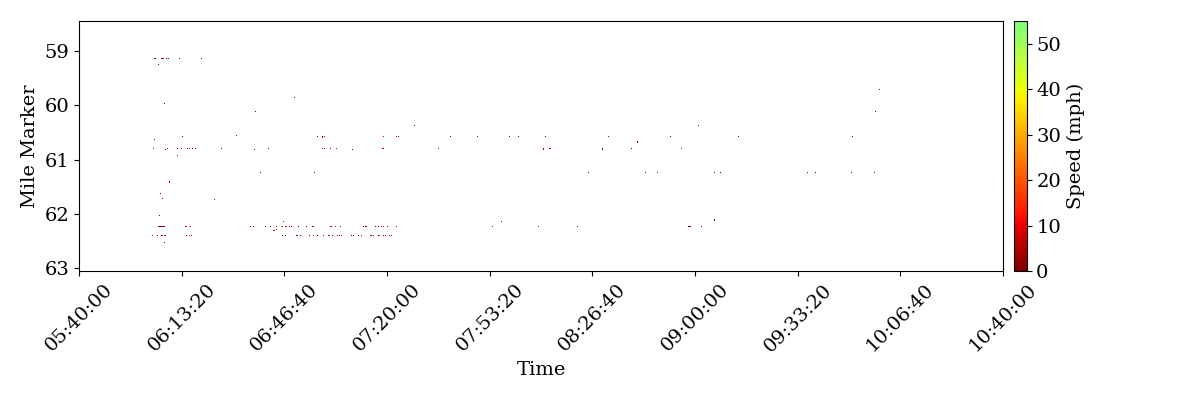

In [11]:
interactive_plot_congestion_with_edie(trajs_light, dt=DT_SECONDS, dx=DX_FEET, edie_grid=edie_heavy,
                                       polygons_by_label={
            "light_sub_20": simplified_polygons_light,
            "heavy_sub_10": simplified_polygons_heavy,
        })


Saved plot to ./output/post4/plot_637f0d5f78f0cb97981425de__post4_2_cong_and_edie_poly.png


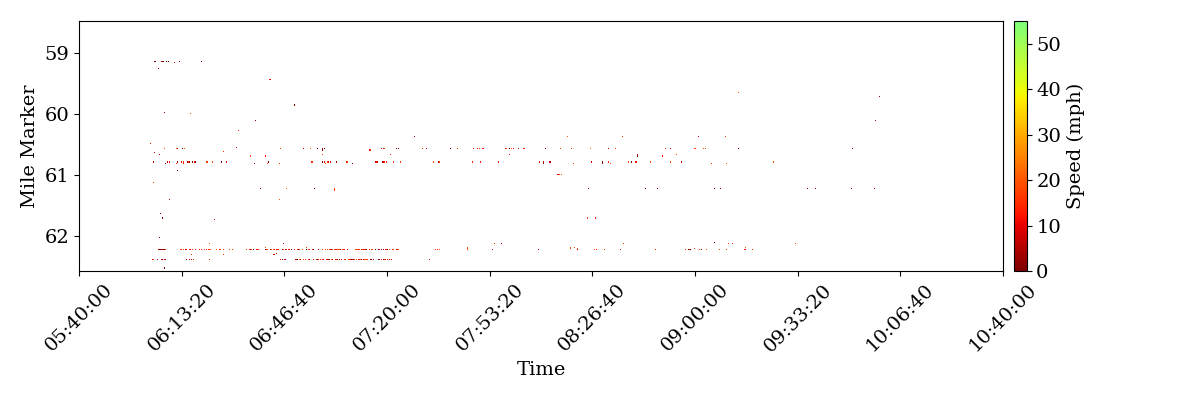

In [12]:
interactive_plot_edies_polys(trajs_light, dt=DT_SECONDS, dx=DX_FEET, edie_grid_light=edie_light, edie_grid_heavy=edie_heavy, polygons_by_label={
                                                                                                    "light_sub_20": simplified_polygons_light,
                                                                                                    "heavy_sub_10": simplified_polygons_heavy,
                                                                                                })

In [13]:
import pandas as pd

# --- Step 1: Convert Edie cells to polygons ---
def edie_cells_to_polygons(edie_dict, dx, dt):
    print(f"Converting {len(edie_dict)} Edie cells to polygons...")
    polys = []
    for (x_bin, t_bin), cell in edie_dict.items():
        if cell["time"] == 0:
            continue
        polys.append(edie_cell_to_polygon(x_bin, t_bin, dx, dt))
    print(f"Converted to {len(polys)} polygons (excluding zero-time cells).")
    return polys

print("Starting conversion of Edie light polygons...")
edie_light_polygons = edie_cells_to_polygons(edie_light, dx=DX_FEET, dt=DT_SECONDS)
print("Starting conversion of Edie heavy polygons...")
edie_heavy_polygons = edie_cells_to_polygons(edie_heavy, dx=DX_FEET, dt=DT_SECONDS)

# Calculate total area of a polygon set
def total_area(polygons):
    return sum(p.area for p in polygons)

# Put all polygon sets in a dict
poly_sets = {
    "Light Edie": edie_light_polygons,
    "Heavy Edie": edie_heavy_polygons,
    "Light Poly": simplified_polygons_light_miles,
    "Heavy Poly": simplified_polygons_heavy_miles,
}

print("\nStarting pairwise area comparisons...\n")
results = []
for gt_name, gt_polys in poly_sets.items():
    gt_area = total_area(gt_polys)
    #print(f"Truth '{gt_name}' total area: {gt_area:.4f}")
    for pred_name, pred_polys in poly_sets.items():
        if gt_name == pred_name:
            continue
        pred_area = total_area(pred_polys)
        coverage_pct = (pred_area / gt_area * 100) if gt_area > 0 else 0
        #print(f"  Approximated by '{pred_name}' total area: {pred_area:.4f} → Coverage: {coverage_pct:.2f}%")
        results.append({
            "Truth": gt_name,
            "Approximated by": pred_name,
            "Coverage %": coverage_pct
        })

print("\nPairwise area coverage results:")
df_results = pd.DataFrame(results)
# Sort by absolute distance from 100%
df_results_sorted = df_results.iloc[
    (df_results["Coverage %"] - 100).abs().argsort()
]

# Reorder columns: 'Approximated by' first, then 'Truth', then 'Coverage %'
df_results_sorted = df_results_sorted[["Approximated by", "Truth", "Coverage %"]].round(2)

save_df(df_results_sorted, "coverage")
print(df_results_sorted)





Starting conversion of Edie light polygons...
Converting 1356 Edie cells to polygons...
Converted to 1356 polygons (excluding zero-time cells).
Starting conversion of Edie heavy polygons...
Converting 563 Edie cells to polygons...
Converted to 563 polygons (excluding zero-time cells).

Starting pairwise area comparisons...


Pairwise area coverage results:
Saved DataFrame to ./output/post4/df_637f0d5f78f0cb97981425de__post4_coverage.csv
   Approximated by       Truth  Coverage %
0       Heavy Edie  Light Edie       41.52
1       Light Poly  Light Edie        0.00
2       Heavy Poly  Light Edie        0.00
4       Light Poly  Heavy Edie        0.00
5       Heavy Poly  Heavy Edie        0.00
6       Light Edie  Light Poly        0.00
7       Heavy Edie  Light Poly        0.00
8       Heavy Poly  Light Poly        0.00
9       Light Edie  Heavy Poly        0.00
10      Heavy Edie  Heavy Poly        0.00
11      Light Poly  Heavy Poly        0.00
3       Light Edie  Heavy Edie      240.85


In [14]:
coverage_matrix = df_results_sorted.pivot(index="Approximated by", columns="Truth", values="Coverage %")

# Fill NaN with 100
coverage_matrix_filled = coverage_matrix.fillna(100)

# Now explicitly set diagonal (where index == column) to 100
for val in coverage_matrix_filled.index.intersection(coverage_matrix_filled.columns):
    coverage_matrix_filled.loc[val, val] = 100

print(coverage_matrix_filled.round(2))


Truth            Heavy Edie  Heavy Poly  Light Edie  Light Poly
Approximated by                                                
Heavy Edie           100.00         0.0       41.52         0.0
Heavy Poly             0.00       100.0        0.00         0.0
Light Edie           240.85         0.0      100.00         0.0
Light Poly             0.00         0.0        0.00       100.0
